## Initial Imports

In [2]:
# imports a library 'pandas', names it as 'pd'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import glob
import os
import googlemaps 
import re as re
import seaborn as sns
import locale
from locale import atof
import math as math
import dateutil
from dateutil import parser


from IPython.display import Image

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline

In [3]:
#Set display parameters
# set various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',50)
pd.set_option('display.precision', 3)

## Get locations: 
* Read in median data per zip code from:
    * ACS csv
    * Stations w/ zips from other notebook with Google geolocation API
    
Merge 2 data frames and drop missing data from New Jersey (7 rows)



In [4]:
acs = pd.read_csv('ACS_zip2.csv')
acs.rename(columns={'Zip':'zipcode'}, inplace=True)
acs.head()
locale.setlocale(locale.LC_NUMERIC, '')

'en_US.UTF-8'

In [5]:
acs.head()

,zipcode,Median,Median_adjusted,Mean
0,10119,"61,350","61,350","94,291"
1,11243,"116,342","116,342","170,485"
2,10106,"130,082","130,082","203,395"
3,10001,"71,245","79,794","123,113"
4,10002,"30,844","34,545","46,259"


In [6]:
acs['Median'] = acs[['Median']].applymap(atof);
acs['Median_adjusted'] = acs[['Median_adjusted']].applymap(atof);


In [7]:
acs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30246 entries, 0 to 30245
Data columns (total 4 columns):
zipcode            30246 non-null int64
Median             30246 non-null float64
Median_adjusted    30246 non-null float64
Mean               30246 non-null object
dtypes: float64(2), int64(1), object(1)
memory usage: 945.3+ KB


In [8]:
#load in station zipcodes from google api calls in Benson_geolocation_final
stations = pd.read_csv('zipcode_df.csv')
stations.shape

(366, 3)

In [9]:
merged = pd.merge(stations,acs,on='zipcode', how = 'left')

In [10]:
merged.isnull().sum()

Unnamed: 0         0
STATION            0
zipcode            0
Median             7
Median_adjusted    7
Mean               7
dtype: int64

In [11]:
#drop 7 stations that don't have data and are in New Jersey - from 366 rows to 359
merged = merged[merged['Median'].notnull()]

In [12]:
merged = merged.drop(columns=['Unnamed: 0'])

In [13]:
len(merged)

359

## Merge location and income with turnstile data

In [14]:
# Read NYC turntable for the month of march, from march 3rd to march 30th (4weeks)
#df = pd.read_csv("NYCT180310.csv")
path =r'/Users/mayamidzik/metis/01-benson' # use your path
all_files = glob.glob(os.path.join(path, "NYCT*.csv"))
all_files
df = pd.concat((pd.read_csv(f) for f in all_files))
df.columns = df.columns.str.strip()
df;

In [15]:
df_m = pd.merge(df,merged,on='STATION')

In [16]:
df_mr = df_m[df_m.ENTRIES != 0]
len(df_mr[df_mr["ENTRIES"] == 0])
print("removed", len(df_m) - len(df_mr), "entries")

removed 12338 entries


In [17]:
len(list(df_mr.STATION.unique()))

359

In [18]:
df_mr.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,zipcode,Median,Median_adjusted,Mean
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/03/2018,03:00:00,REGULAR,6535802,2213345,11207,34729.0,38897.0,"44,634"
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/03/2018,07:00:00,REGULAR,6535813,2213356,11207,34729.0,38897.0,"44,634"
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/03/2018,11:00:00,REGULAR,6535865,2213436,11207,34729.0,38897.0,"44,634"
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/03/2018,15:00:00,REGULAR,6536048,2213481,11207,34729.0,38897.0,"44,634"
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/03/2018,19:00:00,REGULAR,6536326,2213531,11207,34729.0,38897.0,"44,634"


In [19]:
#create a datetime and add it as the 6th index
date_time = pd.to_datetime(df_mr.DATE + " " + df_mr.TIME, format="%m/%d/%Y %H:%M:%S")
df_mr.insert(loc=6, column='DATE_TIME', value=date_time)

In [20]:
#create a datetime date and add it as the 7th index
date_date = pd.to_datetime(df_mr.DATE, format="%m/%d/%Y")
df_mr.insert(loc=7, column='DATE_DATE', value=date_date)

In [21]:
#create a datetime time and add it as the 9th index
time = df_mr.DATE_TIME.dt.time
df_mr.insert(loc=9, column = "TIME_TIME", value=time)

In [22]:
#add day of week
day_of_week = df_mr.DATE_TIME.dt.weekday
df_mr.insert(loc=5, column='day_of_week', value=day_of_week)
df_mr.head();

In [23]:
df_mr.head()

,C/A,UNIT,SCP,STATION,LINENAME,day_of_week,DIVISION,DATE_TIME,DATE_DATE,DATE,TIME_TIME,TIME,DESC,ENTRIES,EXITS,zipcode,Median,Median_adjusted,Mean
0,A002,R051,02-00-00,59 ST,NQR456W,5,BMT,2018-03-03 03:00:00,2018-03-03,03/03/2018,03:00:00,03:00:00,REGULAR,6535802,2213345,11207,34729.0,38897.0,"44,634"
1,A002,R051,02-00-00,59 ST,NQR456W,5,BMT,2018-03-03 07:00:00,2018-03-03,03/03/2018,07:00:00,07:00:00,REGULAR,6535813,2213356,11207,34729.0,38897.0,"44,634"
2,A002,R051,02-00-00,59 ST,NQR456W,5,BMT,2018-03-03 11:00:00,2018-03-03,03/03/2018,11:00:00,11:00:00,REGULAR,6535865,2213436,11207,34729.0,38897.0,"44,634"
3,A002,R051,02-00-00,59 ST,NQR456W,5,BMT,2018-03-03 15:00:00,2018-03-03,03/03/2018,15:00:00,15:00:00,REGULAR,6536048,2213481,11207,34729.0,38897.0,"44,634"
4,A002,R051,02-00-00,59 ST,NQR456W,5,BMT,2018-03-03 19:00:00,2018-03-03,03/03/2018,19:00:00,19:00:00,REGULAR,6536326,2213531,11207,34729.0,38897.0,"44,634"


# Final  Aggregate Table = df_mr

# Get aggregate weekday entries per station

In [24]:
df_wd = df_mr[df_mr['day_of_week'] < 5]
#there are only Mon - Fri data (0 - 4)
df_wd.describe()

,day_of_week,ENTRIES,EXITS,zipcode,Median,Median_adjusted
count,529381.000,5.294e+05,5.294e+05,529381.000,529381.000,529381.000
mean,1.996,4.152e+07,3.444e+07,10608.816,64743.867,72166.685
std,1.414,2.110e+08,1.966e+08,697.615,29686.669,32935.504
min,0.000,1.000e+00,0.000e+00,10001.000,18024.000,20187.000
25%,1.000,6.610e+05,3.299e+05,10021.000,39955.000,44750.000
50%,2.000,2.961e+06,1.665e+06,10453.000,56103.000,62650.000
75%,3.000,7.347e+06,5.108e+06,11217.000,92175.000,103236.000
max,4.000,2.130e+09,2.146e+09,19104.000,145459.000,162914.000


In [25]:
#Get the entries difference by finding the difference for each turnstiles day
#helps eliminate errors with weird turnstile jump
gb_enter = df_wd.groupby(["C/A", "UNIT", "SCP", "STATION", "LINENAME", "DATE"]).ENTRIES.agg(["min", "max"])
gb_enter["dif"] = gb_enter["max"] - gb_enter["min"]

In [26]:
#gb_enter[gb_enter.dif > 15000];

### Looking at the data, it seems obvious that some of these entries have been reset (The ones where min are VERY low compared to the max. We can now get a better sense of the correct cutoff to not remove the entries that did not seem to reset, i.e. 15,000

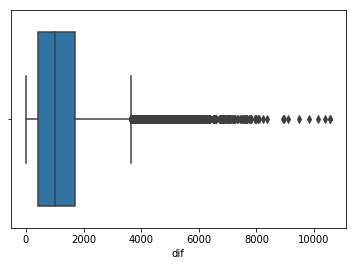

In [27]:
gb_enter_r = gb_enter[gb_enter.dif < 15000]
sns.boxplot(gb_enter_r.dif);

In [28]:
gb_enter_r = gb_enter_r.reset_index()
gb_enter_r.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,min,max,dif
0,A002,R051,02-00-00,59 ST,NQR456W,03/05/2018,6537057,6538436,1379
1,A002,R051,02-00-00,59 ST,NQR456W,03/06/2018,6538452,6539924,1472
2,A002,R051,02-00-00,59 ST,NQR456W,03/07/2018,6539944,6540923,979
3,A002,R051,02-00-00,59 ST,NQR456W,03/08/2018,6540936,6542356,1420
4,A002,R051,02-00-00,59 ST,NQR456W,03/09/2018,6542379,6543867,1488


In [29]:
#Sum accross all days and turnstiles for a station to find the aggregate traffic at that station & line
gb_enter_f = gb_enter_r.groupby(["STATION","LINENAME"]).agg("sum").sort_values("dif", ascending=False)


In [30]:
gb_enter_f.head()

,,min,max,dif
STATION,LINENAME,,,
GRD CNTRL-42 ST,4567S,30349766412,30352559294,2792882
34 ST-HERALD SQ,BDFMNQRW,111892388908,111894536932,2148024
42 ST-PORT AUTH,ACENQRS1237W,149623900039,149625487234,1587195
34 ST-PENN STA,ACE,33317940499,33319361310,1420811
14 ST-UNION SQ,LNQR456W,8882667297,8883869230,1201933


In [31]:
gb_enter_f = gb_enter_f.reset_index()

In [32]:
#take only the columns we need
gb_enter_final = gb_enter_f[['STATION','LINENAME','dif']]

# Get aggregate weekday exits per station

In [33]:
#repeat entry steps to get aggregate counts for station over the time period
gb_exit = df_wd.groupby(["C/A", "UNIT", "SCP", "STATION", "LINENAME", "DATE"]).EXITS.agg(["min", "max"])
gb_exit["exit_dif"] = gb_exit["max"] - gb_exit["min"]

In [34]:
#gb_exit[gb_exit.exit_dif > 15000]

In [35]:
#toss out diffs > 1500 again

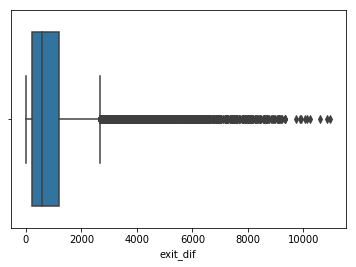

In [36]:
gb_exit_r = gb_exit[gb_exit.exit_dif < 15000]
sns.boxplot(gb_exit_r.exit_dif);

In [37]:
gb_exit_r = gb_exit_r.reset_index()
gb_exit_r.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,min,max,exit_dif
0,A002,R051,02-00-00,59 ST,NQR456W,03/05/2018,2213744,2214234,490
1,A002,R051,02-00-00,59 ST,NQR456W,03/06/2018,2214235,2214769,534
2,A002,R051,02-00-00,59 ST,NQR456W,03/07/2018,2214771,2215192,421
3,A002,R051,02-00-00,59 ST,NQR456W,03/08/2018,2215196,2215689,493
4,A002,R051,02-00-00,59 ST,NQR456W,03/09/2018,2215698,2216223,525


In [38]:
gb_exit_f = gb_exit_r.groupby(["STATION","LINENAME"]).agg("sum").sort_values("exit_dif", ascending=False)
gb_exit_f = gb_exit_f.reset_index()


In [39]:
gb_exit_final = gb_exit_f[['STATION','LINENAME','exit_dif']]

In [40]:
gb_exit_final.sort_values(by=['STATION','LINENAME']);

## Join together entries, exits and income per stations

In [41]:
#join entries and exits
enter_exit_merge = pd.merge(gb_enter_final,gb_exit_final,on=['STATION','LINENAME'])


In [42]:
enter_exit_merge.head()

,STATION,LINENAME,dif,exit_dif
0,GRD CNTRL-42 ST,4567S,2792882,2563697
1,34 ST-HERALD SQ,BDFMNQRW,2148024,2019263
2,42 ST-PORT AUTH,ACENQRS1237W,1587195,1101044
3,34 ST-PENN STA,ACE,1420811,1297313
4,14 ST-UNION SQ,LNQR456W,1201933,1142152


In [43]:
merged.head()

,STATION,zipcode,Median,Median_adjusted,Mean
0,59 ST,11207,34729.0,38897.0,"44,634"
1,5 AV/59 ST,10022,93107.0,104279.0,"158,965"
2,57 ST-7 AV,10106,130082.0,130082.0,"203,395"
3,49 ST,10020,113846.0,127508.0,"147,680"
4,TIMES SQ-42 ST,10018,84799.0,94975.0,"112,292"


In [44]:
#join income
traffic_income_merge = pd.merge(enter_exit_merge,merged,on='STATION')



In [45]:
total_traffic = traffic_income_merge.dif + traffic_income_merge.exit_dif
traffic_income_merge.insert(loc=2, column='total_traffic', value=total_traffic)


In [46]:
traffic_income_merge.sort_values("total_traffic", ascending=False).head()

,STATION,LINENAME,total_traffic,dif,exit_dif,zipcode,Median,Median_adjusted,Mean
0,GRD CNTRL-42 ST,4567S,5356579,2792882,2563697,10017,102524.0,114826.0,"149,724"
1,34 ST-HERALD SQ,BDFMNQRW,4167287,2148024,2019263,11003,78863.0,88326.0,"91,208"
4,34 ST-PENN STA,ACE,2718124,1420811,1297313,10119,61350.0,61350.0,"94,291"
2,42 ST-PORT AUTH,ACENQRS1237W,2688239,1587195,1101044,10036,62393.0,69881.0,"89,879"
7,14 ST-UNION SQ,LNQR456W,2344085,1201933,1142152,10003,89999.0,100798.0,"139,331"


In [47]:
 traffic_income_merge.total_traffic.std()

495131.99566169345

In [49]:
traffic_income_merge.sort_values("total_traffic", ascending=False).head()


,STATION,LINENAME,total_traffic,dif,exit_dif,zipcode,Median,Median_adjusted,Mean
0,GRD CNTRL-42 ST,4567S,5356579,2792882,2563697,10017,102524.0,114826.0,"149,724"
1,34 ST-HERALD SQ,BDFMNQRW,4167287,2148024,2019263,11003,78863.0,88326.0,"91,208"
4,34 ST-PENN STA,ACE,2718124,1420811,1297313,10119,61350.0,61350.0,"94,291"
2,42 ST-PORT AUTH,ACENQRS1237W,2688239,1587195,1101044,10036,62393.0,69881.0,"89,879"
7,14 ST-UNION SQ,LNQR456W,2344085,1201933,1142152,10003,89999.0,100798.0,"139,331"


In [50]:
traffic_income_merge

,STATION,LINENAME,total_traffic,dif,exit_dif,zipcode,Median,Median_adjusted,Mean
0,GRD CNTRL-42 ST,4567S,5356579,2792882,2563697,10017,102524.0,114826.0,"149,724"
1,34 ST-HERALD SQ,BDFMNQRW,4167287,2148024,2019263,11003,78863.0,88326.0,"91,208"
2,42 ST-PORT AUTH,ACENQRS1237W,2688239,1587195,1101044,10036,62393.0,69881.0,"89,879"
3,42 ST-PORT AUTH,ACENGRS1237W,472646,225539,247107,10036,62393.0,69881.0,"89,879"
4,34 ST-PENN STA,ACE,2718124,1420811,1297313,10119,61350.0,61350.0,"94,291"
5,34 ST-PENN STA,123ACE,1658447,966605,691842,10119,61350.0,61350.0,"94,291"
6,34 ST-PENN STA,123,1177853,578851,599002,10119,61350.0,61350.0,"94,291"
7,14 ST-UNION SQ,LNQR456W,2344085,1201933,1142152,10003,89999.0,100798.0,"139,331"
8,14 ST-UNION SQ,456LNQRW,1007509,530972,476537,10003,89999.0,100798.0,"139,331"
9,FULTON ST,2345ACJZ,2331046,1179449,1151597,10038,55937.0,62650.0,"89,760"


# Evaluate High Income Stations, traffic for selection

Text(0.5,1,'Station Weekday Traffic vs Income')

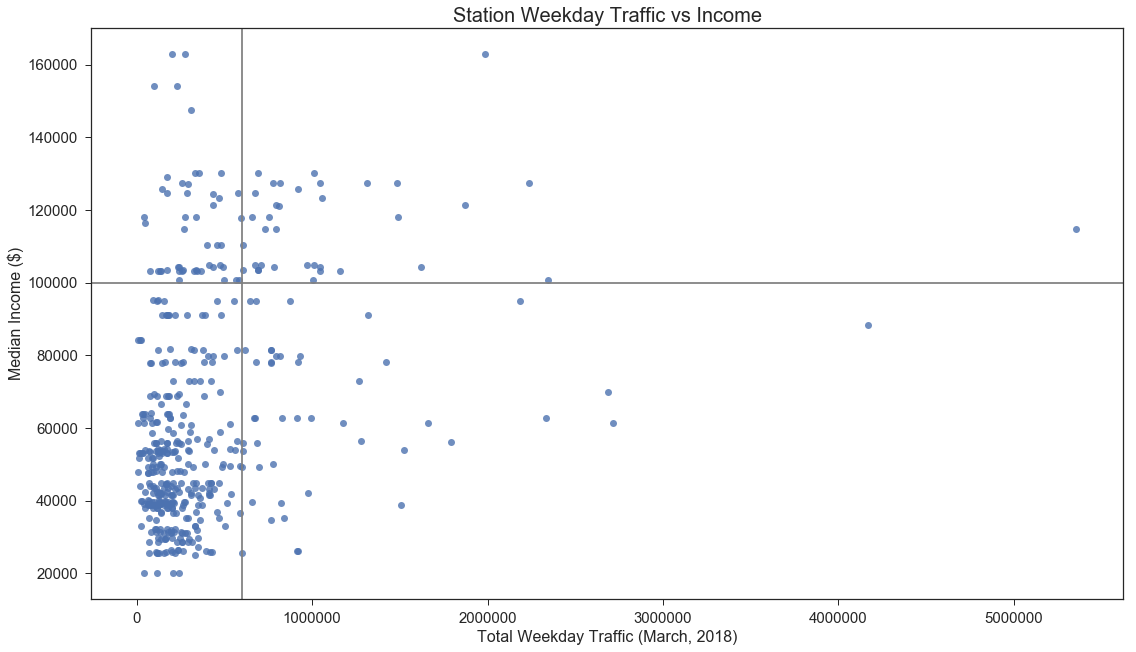

In [52]:
#declare threshold for demographic
min_income = 100000
min_traffic = 600000


#graph income vs traffic for stations for selection
sns.set(font_scale=1.5)
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
sns.regplot(x="total_traffic", y="Median_adjusted", fit_reg = False,data=traffic_income_merge)
plt.axhline(min_income, color='grey')
plt.axvline(min_traffic, color='grey')
plt.ylabel('Median Income ($)', fontsize=16)
plt.xlabel('Total Weekday Traffic (March, 2018)', fontsize=16)
plt.title('Station Weekday Traffic vs Income', fontsize=20)


In [53]:
#check the number of stations in selected area
len(traffic_income_merge[(traffic_income_merge['total_traffic'] >= min_traffic) & (traffic_income_merge['Median_adjusted'] >=min_income)])


36

In [54]:
#subset dataframe with ony these stations
top_income_stops = traffic_income_merge[(traffic_income_merge['total_traffic'] >= min_traffic) & (traffic_income_merge['Median_adjusted'] >=min_income)].sort_values("total_traffic", ascending=False)


In [55]:
top_income_stops

,STATION,LINENAME,total_traffic,dif,exit_dif,zipcode,Median,Median_adjusted,Mean
0,GRD CNTRL-42 ST,4567S,5356579,2792882,2563697,10017,102524.0,114826.0,"149,724"
7,14 ST-UNION SQ,LNQR456W,2344085,1201933,1142152,10003,89999.0,100798.0,"139,331"
15,47-50 STS ROCK,BDFM,2237859,1052188,1185671,10020,113846.0,127508.0,"147,680"
17,PATH NEW WTC,1,1984050,1025965,958085,10007,145459.0,162914.0,"256,236"
18,59 ST COLUMBUS,ABCD1,1874297,1007076,867221,10023,108286.0,121280.0,"194,366"
24,LEXINGTON AV/53,EM6,1623380,772866,850514,10022,93107.0,104279.0,"158,965"
25,86 ST,456,1492247,760903,731344,10028,105456.0,118111.0,"192,258"
35,42 ST-BRYANT PK,BDFM7,1482163,724072,758091,10021,113800.0,127456.0,"198,530"
37,72 ST,123,1315265,674341,640924,10021,113800.0,127456.0,"198,530"
30,JAY ST-METROTEC,ACF,1160393,748077,412316,11201,92175.0,103236.0,"140,858"


# Get the stations near technical companies/HS

In [247]:
techies = pd.read_csv('stations_near_tech.csv')

In [578]:
techies.head()

,STATION,near_tech
0,103 ST,Y
1,14 ST,Y
2,18 ST,Y
3,23 ST,Y
4,47-50 STS ROCK,Y


# Get entries and exits by time of day for all stations

## Creating a column for time differences between exits and entrance

In [249]:
df_mr.head()
#copy table for work
df_mr_daily = df_mr
df_mr_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,day_of_week,DIVISION,DATE_TIME,DATE_DATE,DATE,TIME_TIME,TIME,DESC,ENTRIES,EXITS,zipcode,Median,Median_adjusted,Mean
0,A002,R051,02-00-00,59 ST,NQR456W,5,BMT,2018-03-03 03:00:00,2018-03-03,03/03/2018,03:00:00,03:00:00,REGULAR,6535802,2213345,11207,34729.0,38897.0,"44,634"
1,A002,R051,02-00-00,59 ST,NQR456W,5,BMT,2018-03-03 07:00:00,2018-03-03,03/03/2018,07:00:00,07:00:00,REGULAR,6535813,2213356,11207,34729.0,38897.0,"44,634"
2,A002,R051,02-00-00,59 ST,NQR456W,5,BMT,2018-03-03 11:00:00,2018-03-03,03/03/2018,11:00:00,11:00:00,REGULAR,6535865,2213436,11207,34729.0,38897.0,"44,634"
3,A002,R051,02-00-00,59 ST,NQR456W,5,BMT,2018-03-03 15:00:00,2018-03-03,03/03/2018,15:00:00,15:00:00,REGULAR,6536048,2213481,11207,34729.0,38897.0,"44,634"
4,A002,R051,02-00-00,59 ST,NQR456W,5,BMT,2018-03-03 19:00:00,2018-03-03,03/03/2018,19:00:00,19:00:00,REGULAR,6536326,2213531,11207,34729.0,38897.0,"44,634"


In [250]:
# NEW DATA FRAME: grpb is grouped by TS and DATE
sorted_df_mr_daytime_entry = df_mr_daily.sort_values(by=["C/A", "UNIT", "SCP", "STATION", "LINENAME", "DATE_TIME"])


In [579]:
sorted_df_mr_daytime_entry.head();

In [252]:
#Get Entries Hourly diff
#group by turnstile identifiers, and get the difference between the time points & one before within each turnstile/date
#will result in NANs where there is no vlaue preceeding group_by 

sorted_df_mr_daytime_entry['entry_diff'] = sorted_df_mr_daytime_entry.groupby(["C/A", "UNIT", "SCP", "STATION", "LINENAME",'DATE_DATE'])['ENTRIES'].transform(lambda x:x.diff())





In [253]:
#Get Exits Hourly diff
sorted_df_mr_daytime_entry['exits_diff'] = sorted_df_mr_daytime_entry.groupby(["C/A", "UNIT", "SCP", "STATION", "LINENAME",'DATE_DATE'])['EXITS'].transform(lambda x:x.diff())



In [254]:
len(sorted_df_mr_daytime_entry)

737939

In [255]:
sorted_df_mr_daytime_entry = sorted_df_mr_daytime_entry[(sorted_df_mr_daytime_entry["exits_diff"] > 0) | (sorted_df_mr_daytime_entry["entry_diff"] > 0)]
len(sorted_df_mr_daytime_entry) 
                                                        

548816

In [256]:
#remove weekends from this dataframe
sorted_df_mr_daytime_wd = sorted_df_mr_daytime_entry[sorted_df_mr_daytime_entry['day_of_week'] < 5]
#df_mr_daily_wd.head()

In [257]:
sorted_df_mr_daytime_wd.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,day_of_week,DIVISION,DATE_TIME,DATE_DATE,DATE,TIME_TIME,TIME,DESC,ENTRIES,EXITS,zipcode,Median,Median_adjusted,Mean,entry_diff,exits_diff
13,A002,R051,02-00-00,59 ST,NQR456W,0,BMT,2018-03-05 07:00:00,2018-03-05,03/05/2018,07:00:00,07:00:00,REGULAR,6537067,2213787,11207,34729.0,38897.0,"44,634",10.0,43.0
14,A002,R051,02-00-00,59 ST,NQR456W,0,BMT,2018-03-05 11:00:00,2018-03-05,03/05/2018,11:00:00,11:00:00,REGULAR,6537229,2214053,11207,34729.0,38897.0,"44,634",162.0,266.0
15,A002,R051,02-00-00,59 ST,NQR456W,0,BMT,2018-03-05 15:00:00,2018-03-05,03/05/2018,15:00:00,15:00:00,REGULAR,6537432,2214131,11207,34729.0,38897.0,"44,634",203.0,78.0
16,A002,R051,02-00-00,59 ST,NQR456W,0,BMT,2018-03-05 19:00:00,2018-03-05,03/05/2018,19:00:00,19:00:00,REGULAR,6538196,2214201,11207,34729.0,38897.0,"44,634",764.0,70.0
17,A002,R051,02-00-00,59 ST,NQR456W,0,BMT,2018-03-05 23:00:00,2018-03-05,03/05/2018,23:00:00,23:00:00,REGULAR,6538436,2214234,11207,34729.0,38897.0,"44,634",240.0,33.0


## Find average ridership entry for each time of day

In [258]:
#group by station, linename, and time to get the median traffic for that time point and station
#e.g. The median number of people entering the 1st AV L stop at 8AM (over the month) was 104.5

entries_diff = sorted_df_mr_daytime_wd.groupby(['STATION', 'LINENAME' , 'TIME_TIME'],as_index = False)['entry_diff'].agg("median")
entries_diff.head(10)


,STATION,LINENAME,TIME_TIME,entry_diff
0,1 AV,L,04:00:00,36.5
1,1 AV,L,07:00:00,30.0
2,1 AV,L,08:00:00,104.5
3,1 AV,L,11:00:00,426.5
4,1 AV,L,12:00:00,363.5
5,1 AV,L,15:00:00,257.5
6,1 AV,L,16:00:00,326.5
7,1 AV,L,19:00:00,556.0
8,1 AV,L,20:00:00,421.5
9,1 AV,L,23:00:00,289.5


In [259]:
#repeat with exits
exits_diff = sorted_df_mr_daytime_wd.groupby(['STATION', 'LINENAME' , 'TIME_TIME'], as_index = False)['exits_diff'].agg("median")
exits_diff.head(10)

,STATION,LINENAME,TIME_TIME,exits_diff
0,1 AV,L,04:00:00,30.0
1,1 AV,L,07:00:00,121.5
2,1 AV,L,08:00:00,347.0
3,1 AV,L,11:00:00,649.0
4,1 AV,L,12:00:00,521.5
5,1 AV,L,15:00:00,314.5
6,1 AV,L,16:00:00,301.5
7,1 AV,L,19:00:00,344.5
8,1 AV,L,20:00:00,353.5
9,1 AV,L,23:00:00,283.0


In [260]:
#df_mr_daily_wd.dropna().sort_values(by=['STATION','LINENAME','TIME_TIME'])

In [261]:
#merge aggregated entries and exits
total_daily_time_traffic = pd.merge(exits_diff,entries_diff,on=['STATION','LINENAME','TIME_TIME'])

In [378]:
total_daily_time_traffic.head()

,STATION,LINENAME,TIME_TIME,exits_diff,entry_diff,HOUR
0,1 AV,L,04:00:00,30.0,36.5,4
1,1 AV,L,07:00:00,121.5,30.0,7
2,1 AV,L,08:00:00,347.0,104.5,8
3,1 AV,L,11:00:00,649.0,426.5,11
4,1 AV,L,12:00:00,521.5,363.5,12


In [263]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 8}

plt.rc('font', **font)

In [264]:
#import library for keys
import matplotlib.patches as mpatches

In [265]:
top_income_stops.head(5)

,STATION,LINENAME,total_traffic,dif,exit_dif,zipcode,Median,Median_adjusted,Mean
0,GRD CNTRL-42 ST,4567S,5356579,2792882,2563697,10017,102524.0,114826.0,"149,724"
7,14 ST-UNION SQ,LNQR456W,2344085,1201933,1142152,10003,89999.0,100798.0,"139,331"
15,47-50 STS ROCK,BDFM,2237859,1052188,1185671,10020,113846.0,127508.0,"147,680"
17,PATH NEW WTC,1,1984050,1025965,958085,10007,145459.0,162914.0,"256,236"
18,59 ST COLUMBUS,ABCD1,1874297,1007076,867221,10023,108286.0,121280.0,"194,366"


In [379]:
#create a column for 'hour' for aggregate AM/PM analysis
def hr_func(ts):
    return ts.hour
total_daily_time_traffic['HOUR'] = total_daily_time_traffic['TIME_TIME'].apply(hr_func)
total_daily_time_traffic.head(10)

,STATION,LINENAME,TIME_TIME,exits_diff,entry_diff,HOUR
0,1 AV,L,04:00:00,30.0,36.5,4
1,1 AV,L,07:00:00,121.5,30.0,7
2,1 AV,L,08:00:00,347.0,104.5,8
3,1 AV,L,11:00:00,649.0,426.5,11
4,1 AV,L,12:00:00,521.5,363.5,12
5,1 AV,L,15:00:00,314.5,257.5,15
6,1 AV,L,16:00:00,301.5,326.5,16
7,1 AV,L,19:00:00,344.5,556.0,19
8,1 AV,L,20:00:00,353.5,421.5,20
9,1 AV,L,23:00:00,283.0,289.5,23


# Evaluate AM/PM patterns for Tech Hubs

In [556]:
#merge tech stations with hourly traffic aggregate
techie_traffic = pd.merge(techies,total_daily_time_traffic, on ='STATION' )
techie_traffic.head()

,STATION,near_tech,LINENAME,TIME_TIME,exits_diff,entry_diff,HOUR
0,103 ST,Y,1,04:00:00,4.5,6.5,4
1,103 ST,Y,1,05:00:00,10.0,10.0,5
2,103 ST,Y,1,08:00:00,54.5,237.5,8
3,103 ST,Y,1,09:00:00,124.5,495.0,9
4,103 ST,Y,1,12:00:00,160.5,677.0,12


In [557]:
tech_morning = techie_traffic[(techie_traffic['HOUR'] < 12) & (techie_traffic['HOUR'] > 6)]
tech_morning.head()

,STATION,near_tech,LINENAME,TIME_TIME,exits_diff,entry_diff,HOUR
2,103 ST,Y,1,08:00:00,54.5,237.5,8
3,103 ST,Y,1,09:00:00,124.5,495.0,9
12,103 ST,Y,6,08:00:00,264.0,266.5,8
13,103 ST,Y,6,09:00:00,375.5,445.0,9
22,103 ST,Y,BC,08:00:00,64.0,243.0,8


In [580]:
#Sum median traffic over mroning hours
tech_morning_sum = tech_morning.groupby(['STATION']).sum()
tech_morning_sum = tech_morning_sum.reset_index().sort_values('exits_diff').reset_index()
tech_morning_sum.head()

,index,STATION,exits_diff,entry_diff,HOUR
0,18,LAFAYETTE AV,23.0,28.0,17
1,21,YORK ST,98.0,748.0,17
2,15,FRANKLIN ST,141.5,54.5,17
3,13,CITY HALL,269.0,81.0,26
4,2,18 ST,295.5,192.0,26


In [568]:
#select top to graph
techie_morning_to_graph = tech_morning_sum.iloc[13:21]
techie_morning_to_graph

,index,STATION,exits_diff,entry_diff,HOUR
13,19,LEXINGTON AV/63,800.0,351.0,67
14,0,103 ST,992.5,2164.0,51
15,9,59 ST,1258.5,1843.0,100
16,12,BOROUGH HALL,1354.5,1417.5,144
17,1,14 ST,1383.0,659.5,69
18,6,5 AV/53 ST,1471.0,91.5,53
19,3,23 ST,3378.0,1856.0,135
20,4,47-50 STS ROCK,4587.5,234.5,87


Text(0.5,1,'Tech Hubs: AM Exits Traffic per Station')

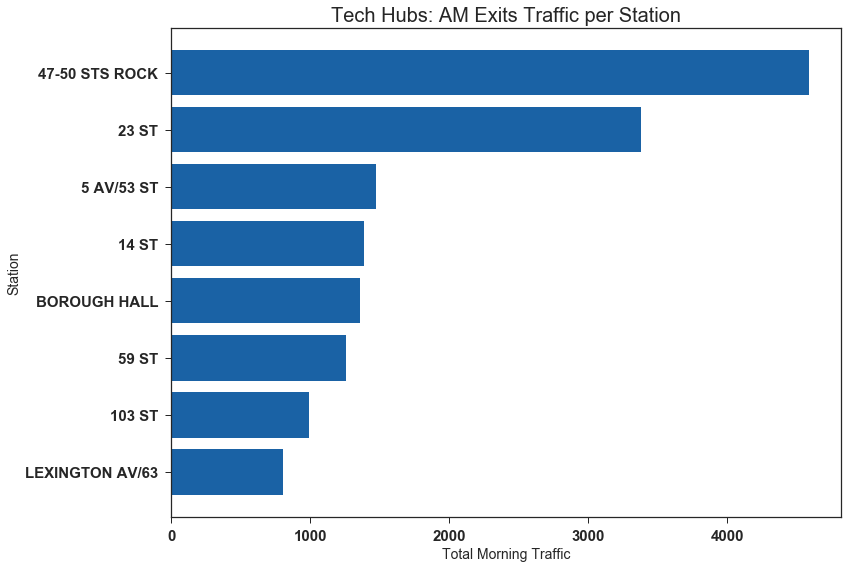

In [569]:
plt.barh(techie_morning_to_graph['STATION'],techie_morning_to_graph['exits_diff'], color = '#1A62A5')
plt.ylabel('Station', fontsize=14)
plt.xlabel('Total Morning Traffic', fontsize=14)
plt.title('Tech Hubs: AM Exits Traffic per Station', fontsize=20)

In [570]:
tech_evening = techie_traffic[(techie_traffic['HOUR'] > 12)]
tech_evening.head()

,STATION,near_tech,LINENAME,TIME_TIME,exits_diff,entry_diff,HOUR
5,103 ST,Y,1,13:00:00,158.0,524.5,13
6,103 ST,Y,1,16:00:00,202.5,403.5,16
7,103 ST,Y,1,17:00:00,235.5,472.5,17
8,103 ST,Y,1,20:00:00,335.0,500.0,20
9,103 ST,Y,1,21:00:00,332.5,457.5,21


In [581]:
tech_evening_sum = tech_evening.groupby(['STATION']).sum()
tech_evening_sum = tech_evening_sum.reset_index().sort_values('exits_diff').reset_index()
tech_evening_sum.head()

,index,STATION,exits_diff,entry_diff,HOUR
0,13,CITY HALL,207.0,1009.0,93
1,18,LAFAYETTE AV,229.5,239.5,87
2,8,5 AVE,284.0,1654.5,93
3,15,FRANKLIN ST,449.5,555.5,87
4,2,18 ST,618.0,976.0,93


In [575]:
techie_evening_to_graph = tech_evening_median.iloc[13:21]
techie_evening_to_graph

,index,STATION,exits_diff,entry_diff,HOUR
13,17,JAY ST-METROTEC,939.5,3339.0,186
14,12,BOROUGH HALL,1139.0,2454.0,186
15,14,DEKALB AV,1387.5,2978.0,186
16,9,59 ST,1961.5,4733.0,279
17,1,14 ST,3308.5,5522.0,273
18,10,8 AV,4527.5,5541.5,174
19,0,103 ST,5114.0,6823.0,261
20,3,23 ST,6879.5,13138.5,453


Text(0.5,1,'Tech Hubs: PM Entries per Station')

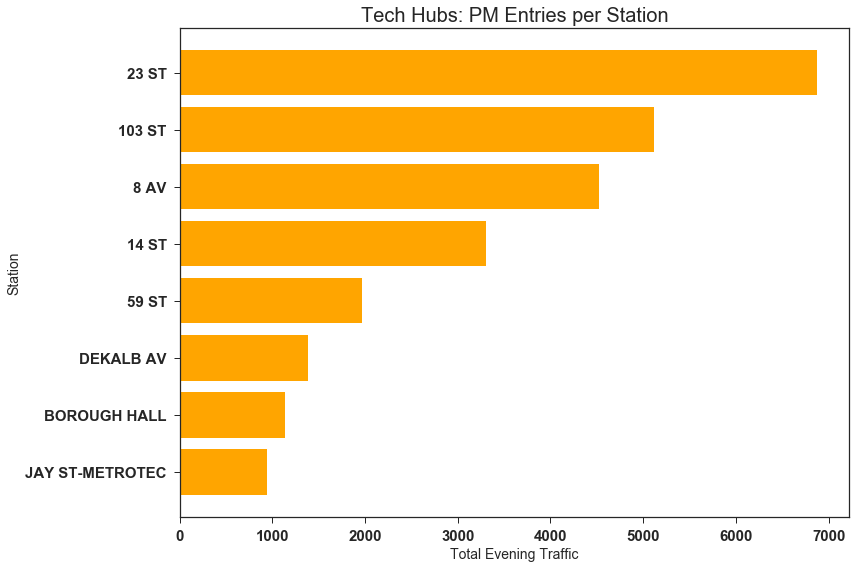

In [577]:
plt.barh(techie_evening_to_graph['STATION'],techie_evening_to_graph['exits_diff'],color = 'orange')
plt.ylabel('Station', fontsize=14)
plt.xlabel('Total Evening Traffic', fontsize=14)
plt.title('Tech Hubs: PM Entries per Station', fontsize=20)

# Evaluate AM/PM patterns for High Income

In [537]:
high_inc_traf = pd.merge(total_daily_time_traffic,top_income_stops, on = ['STATION','LINENAME'])

In [543]:
df_morning = high_inc_traf[(high_inc_traf['HOUR'] < 12) & (high_inc_traf['HOUR'] > 6)]
df_morning;

In [480]:
df_evening = high_inc_traf[(high_inc_traf['HOUR'] > 4)]
df_evening.head()

,STATION,LINENAME,TIME_TIME,exits_diff,entry_diff,HOUR,total_traffic,dif,exit_dif,zipcode,Median,Median_adjusted,Mean
1,1 AV,L,07:00:00,121.5,30.0,7,796391,377432,418959,10017,102524.0,114826.0,"149,724"
2,1 AV,L,08:00:00,347.0,104.5,8,796391,377432,418959,10017,102524.0,114826.0,"149,724"
3,1 AV,L,11:00:00,649.0,426.5,11,796391,377432,418959,10017,102524.0,114826.0,"149,724"
4,1 AV,L,12:00:00,521.5,363.5,12,796391,377432,418959,10017,102524.0,114826.0,"149,724"
5,1 AV,L,15:00:00,314.5,257.5,15,796391,377432,418959,10017,102524.0,114826.0,"149,724"


In [582]:
df_morning_sum = df_morning.groupby(['STATION']).sum()
df_morning_sum = df_morning_sum.reset_index().sort_values('entry_diff').reset_index()
df_morning_sum.head()

,index,STATION,exits_diff,entry_diff,HOUR,total_traffic,dif,exit_dif,zipcode,Median,Median_adjusted
0,22,CORTLANDT ST,241.0,53.5,33,2697084,1503432,1193652,40024,444880.0,498264.0
1,7,5 AV/53 ST,1471.0,91.5,53,6264258,2973360,3290898,60132,558642.0,625674.0
2,8,51 ST,676.0,119.0,33,3124148,1444196,1679952,40088,372428.0,417116.0
3,11,66 ST-LINCOLN,802.5,143.0,33,3173264,1603068,1570196,40092,433144.0,485120.0
4,21,BOWLING GREEN,392.5,164.5,26,3161298,1697226,1464072,30012,330552.0,370218.0


In [583]:
df_evening_sum = df_evening.groupby(['STATION']).sum()
df_evening_sum = df_evening_sum.reset_index().sort_values('exits_diff').reset_index()
df_evening_sum.head()

,index,STATION,exits_diff,entry_diff,HOUR,total_traffic,dif,exit_dif,zipcode,Median,Median_adjusted
0,22,CORTLANDT ST,705.0,776.0,137,7416981,4134438,3282543,110066,1.223e+06,1.370e+06
1,21,BOWLING GREEN,1177.5,3650.0,399,25290384,13577808,11712576,240096,2.644e+06,2.962e+06
2,25,JAY ST-METROTEC,1503.0,3344.5,143,11603930,7480770,4123160,112010,9.218e+05,1.032e+06
3,6,49 ST,1577.0,2207.5,145,8958246,4677167,4281079,110220,1.252e+06,1.403e+06
4,8,51 ST,1813.0,2212.0,267,16401777,7582029,8819748,210462,1.955e+06,2.190e+06


In [548]:
evening_to_graph = df_evening_sum.iloc[18:28,:]

In [549]:
evening_to_graph = evening_to_graph.reset_index().sort_values('exits_diff')

In [553]:
morning_to_graph = df_morning_sum.iloc[18:28,:]
morning_to_graph = morning_to_graph.sort_values('entry_diff')
morning_to_graph

,index,STATION,exits_diff,entry_diff,HOUR,total_traffic,dif,exit_dif,zipcode,Median,Median_adjusted
18,23,GRAND ST,1030.0,626.0,26,2200725,1281858,918867,30051,3.076e+05,3.445e+05
19,1,14 ST,1383.0,659.5,69,5280150,2812284,2467866,80088,7.389e+05,8.275e+05
20,18,86 ST,1257.5,905.5,61,8770405,4478305,4292100,70196,7.382e+05,8.268e+05
21,14,72 ST,644.0,948.5,42,6576325,3371705,3204620,50105,5.690e+05,6.373e+05
22,2,14 ST-UNION SQ,1434.5,1019.5,50,10054782,5198715,4856067,60018,5.400e+05,6.048e+05
23,9,57 ST-7 AV,2809.5,1143.0,93,10090350,6089040,4001310,101060,1.301e+06,1.301e+06
24,20,BOROUGH HALL,1177.5,1159.5,101,12507696,7625628,4882068,134412,1.106e+06,1.239e+06
25,24,GRD CNTRL-42 ST,2233.5,1290.0,67,42852632,22343056,20509576,80136,8.202e+05,9.186e+05
26,3,23 ST,2935.5,1629.0,118,12077482,6775498,5301984,140140,1.312e+06,1.469e+06
27,19,86 ST-2 AVE,445.0,2383.5,59,5284489,3256470,2028019,70196,7.382e+05,8.268e+05


Text(0.5,1,'High Income: PM Exit Traffic per Station')

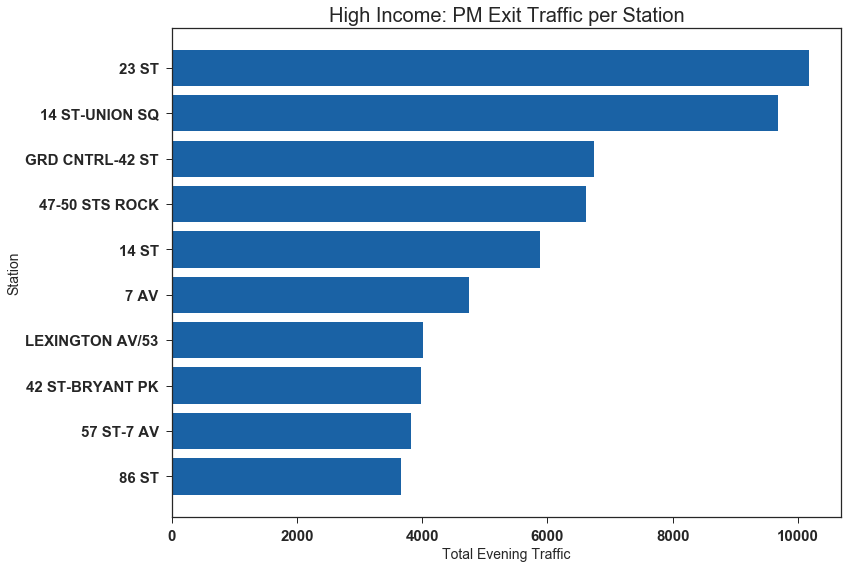

In [551]:
plt.barh(evening_to_graph['STATION'],evening_to_graph['exits_diff'],color = '#1A62A5')
plt.ylabel('Station', fontsize=14)
plt.xlabel('Total Evening Traffic', fontsize=14)
plt.title('High Income: PM Exit Traffic per Station', fontsize=20)


Text(0.5,1,'High Income: AM Entries Traffic per Station')

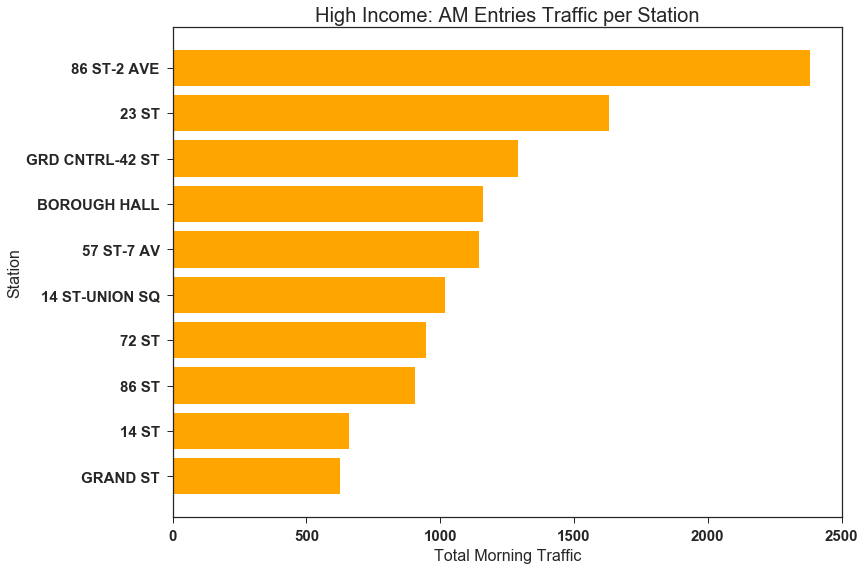

In [554]:
plt.barh(morning_to_graph['STATION'],morning_to_graph['entry_diff'],color = 'orange')
plt.ylabel('Station', fontsize=16)
plt.xlabel('Total Morning Traffic', fontsize=16)
plt.title('High Income: AM Entries Traffic per Station', fontsize=20)

## scrap plots

In [317]:
fig_size = plt.rcParams["figure.figsize"]
print ("Current size:", fig_size)

# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

Current size: [6.0, 4.0]


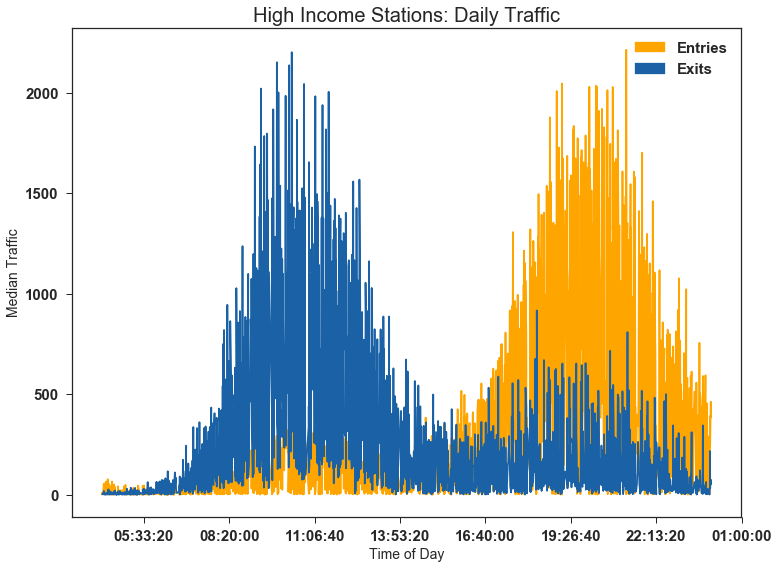

<Figure size 10800x10800 with 0 Axes>

In [529]:
#plot the total traffic over time for all high income stations
#note that this was original written as a for loop to make plots for all stations
#should be cleaned up

plt.close(fig)
name_list = top_income_stops["STATION"].unique()
for i in range(3,4):
    name = name_list[i]
    #print(name)
    station = total_daily_time_traffic[total_daily_time_traffic['STATION']==name]
    #print(station)
    #plt.subplot(29, 1, (i+1))
    plt.plot(station['TIME_TIME'], station['entry_diff'], 'orange', station['TIME_TIME'], station['exits_diff'], '#1A62A5')
    plt.ylabel('Median Traffic', fontsize=14)
    plt.xlabel('Time of Day', fontsize=14)
    key_entry = mpatches.Patch(color='orange', label='Entries')
    key_exit = mpatches.Patch(color='#1A62A5', label='Exits')
    plt.legend(handles=[key_entry,key_exit])
    plt.title('High Income Stations: Daily Traffic', fontsize=20)
    plt.figure(figsize=(150,150))


<Figure size 720x1080 with 0 Axes>

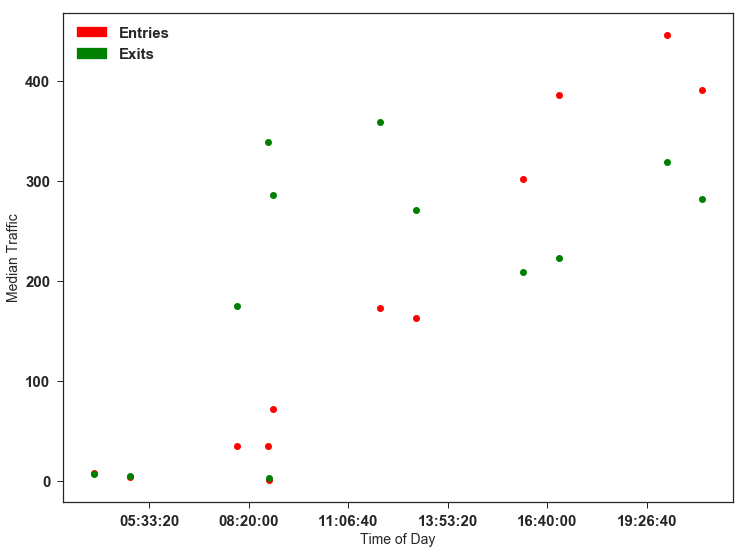

<Figure size 720x1080 with 0 Axes>

In [523]:
#Plot to make time points for a single station over time

# station = total_daily_time_traffic[total_daily_time_traffic['STATION']=='66 ST-LINCOLN']
# #print(station)
# #plt.subplot(29, 1, (i+1))
# plt.plot(station['TIME_TIME'], station['entry_diff'], 'ro', station['TIME_TIME'], station['exits_diff'], 'go')
# plt.ylabel('Median Traffic', fontsize=14)
# plt.xlabel('Time of Day', fontsize=14)
# key_entry = mpatches.Patch(color='red', label='Entries')
# key_exit = mpatches.Patch(color='green', label='Exits')
# plt.legend(handles=[key_entry,key_exit])
# plt.figure(figsize=(10,15))